In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = os.path.join('..', 'aggregated_data.csv')
data = pd.read_csv(file_path)

# inflation adjustment
base_cpi = data['CPI_US'].iloc[-1]
data['AVG_PRICE_AUCTION'] = data['AVG_PRICE_AUCTION'] * (base_cpi/data['CPI_US'])
data['CORN_FUTURES_TYPICAL_PRICE'] = data['CORN_FUTURES_TYPICAL_PRICE'] * (base_cpi/data['CPI_US'])
data['FEEDER_CATTLE_FUTURES_TYPICAL_PRICE'] = data['FEEDER_CATTLE_FUTURES_TYPICAL_PRICE'] * (base_cpi/data['CPI_US'])
data['US_MXN_RATES'] = data['US_MXN_RATES'] * (base_cpi/data['CPI_US'])
data['DIESEL_RETAIL_PRICE'] = data['DIESEL_RETAIL_PRICE'] * (base_cpi/data['CPI_US'])
data['DATE'] = pd.to_datetime(data['DATE'])

data = data.sort_values('DATE', ignore_index=True).set_index('DATE').drop( # drop columns not used for training
    ['avg_price_steers_ML1', 
     'avg_price_steers_ML1_2', 
     'avg_price_heifers_ML1', 
     'avg_price_heifers_ML1_2', 
     'NATIONAL_AUCTION_SALES', 
     'NATIONAL_TOTAL_SALES', 
     'TEXAS_AUCTION_SALES', 
     'CORN_FUTURES_TYPICAL_PRICE', 
     'DIESEL_RETAIL_PRICE', 
     'ALFAFA_HAY_PPI', 
     'CORN_PPI',
    #  'US_MXN_RATES',
     ], axis=1)

print(data.columns)


Index(['AVG_PRICE_AUCTION', 'FEEDER_CATTLE_FUTURES_TYPICAL_PRICE',
       'US_MXN_RATES', 'CPI_US', 'FEDERAL_INTEREST_RATE'],
      dtype='object')


In [3]:
def evaluate_forecast(model_name, actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual,predicted)
    
    acc = 100.0 * (1 - mae / actual.mean()) if actual.mean() != 0 else float('nan')
    print(f"\n[{model_name}] Test Performance:")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}, Accuracy: {acc:.2f}%")

In [4]:
X = data.drop(['AVG_PRICE_AUCTION'], axis=1)
y = data['AVG_PRICE_AUCTION'].values.reshape(-1,1)

train_size = int(len(data.index) * 0.9)

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

In [5]:
# create auto_arima model 
model = auto_arima(y_train,
                  X=X_train,
                  method='lbfgs',
                  solver='lbfgs',
                  information_criterion='bic',
                  start_p=1,
                  start_q=1,
                  max_p=3,
                  max_q=3,
                  seasonal=False,
                  trace=True,
                  random_state=42,
                  error_action='ignore',
                  suppress_warnings=True,
                  stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=2230.178, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=2407.452, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=2319.684, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=2370.094, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=2240.489, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=2234.071, Time=0.34 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=2338.521, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=2272.178, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=2240.154, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=2248.405, Time=0.21 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.991 seconds


In [6]:
# Get in-sample predictions
y_train_pred = model.predict(n_periods=len(y_train), X=X_train)

# Get out-of-sample forecast
y_test_pred = model.predict(n_periods=len(y_test), X=X_test)

evaluate_forecast('SARIMAX: Training Data', y_train, y_train_pred)
evaluate_forecast('SARIMAX: Testing Data', y_test, y_test_pred)

# Print model summary
print("\nModel Summary:")
print(model.summary())


[SARIMAX: Training Data] Test Performance:
MAE: 19.20, RMSE: 21.69, R²: 0.48, Accuracy: 89.70%

[SARIMAX: Testing Data] Test Performance:
MAE: 10.27, RMSE: 13.65, R²: 0.09, Accuracy: 96.14%

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  332
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1094.771
Date:                Fri, 11 Apr 2025   AIC                           2203.542
Time:                        15:27:57   BIC                           2230.178
Sample:                             0   HQIC                          2214.164
                                - 332                                         
Covariance Type:                  opg                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

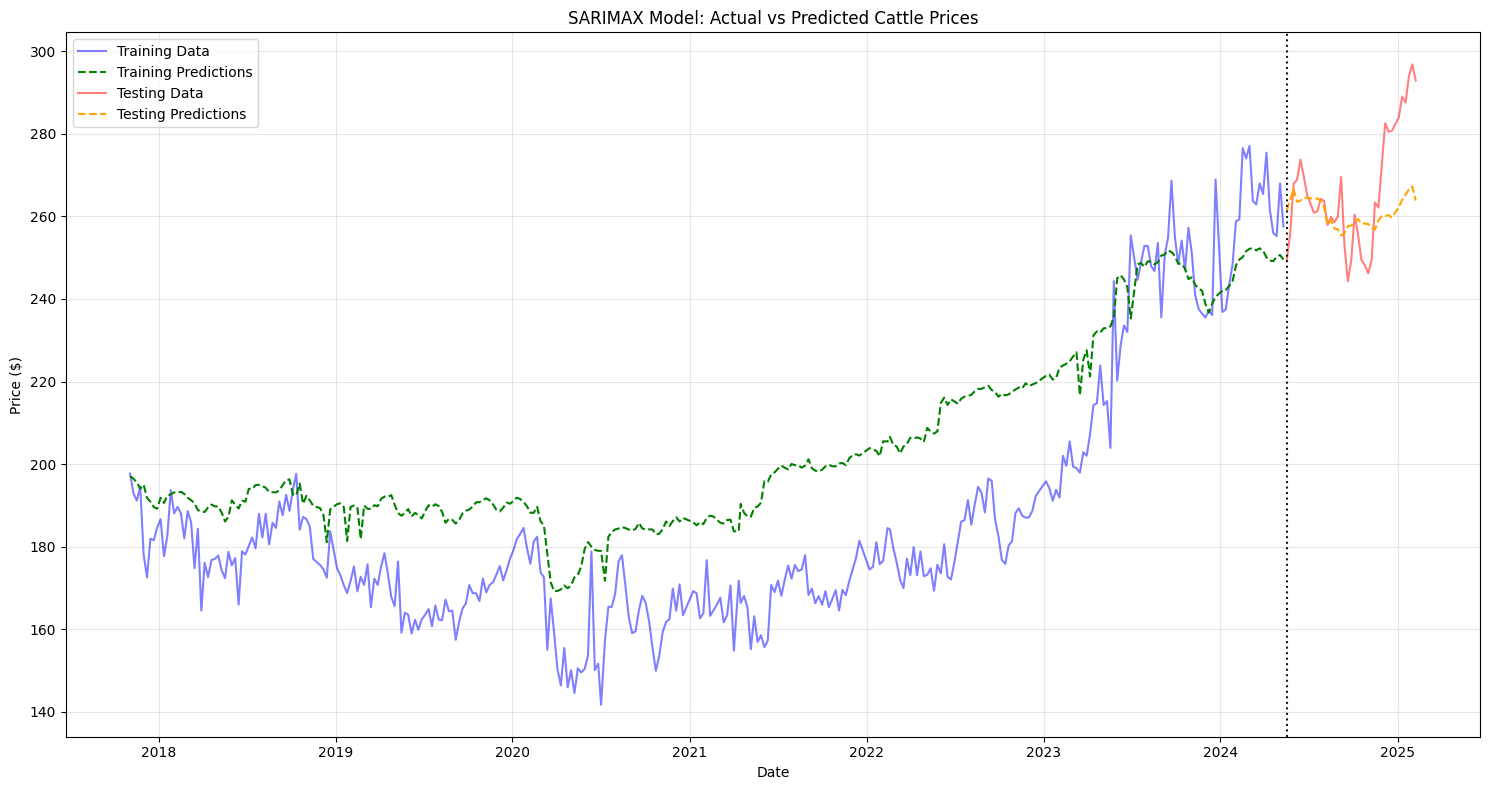

In [7]:
# Plot results
plt.figure(figsize=(15, 8))

# Plot training data and predictions
plt.plot(data.index[:train_size], y_train, label='Training Data', color='blue', alpha=0.5)
plt.plot(data.index[:train_size], y_train_pred, label='Training Predictions', color='green', linestyle='--')

# Plot testing data and predictions
plt.plot(data.index[train_size:], y_test, label='Testing Data', color='red', alpha=0.5)
plt.plot(data.index[train_size:], y_test_pred, label='Testing Predictions', color='orange', linestyle='--')

# Customize plot
plt.title('SARIMAX Model: Actual vs Predicted Cattle Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add vertical line separating train/test
plt.axvline(x=data.index[train_size], color='black', linestyle=':', alpha=0.9)
plt.tight_layout()
plt.savefig(os.path.join('..', 'figures', 'sarimax_plot.png'), dpi=300)
plt.show()
